In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use("fivethirtyeight")

path = ""

In [2]:
# Uncomment cell if using Google Colab

from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/csc-461-final-project/"

Mounted at /content/drive


In [3]:
Statewide = pd.read_csv(path + "data/Statewide.csv")
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8,TGT STATEWIDE PRIMARY,TGT PARTY AFFILIATION
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2,0,0
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3,1,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0,1,3
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [5]:
Statewide_target = Statewide["TGT STATEWIDE PRIMARY"]
Statewide = Statewide.drop(["TGT STATEWIDE PRIMARY", "TGT PARTY AFFILIATION"], axis = 1)

In [6]:
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0


In [7]:
Statewide_target.head()

0    0
1    0
2    1
3    1
4    0
Name: TGT STATEWIDE PRIMARY, dtype: int64

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(Statewide, Statewide_target, test_size = .50, stratify = Statewide_target)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

randomForest = RandomForestClassifier()
n_estimators = np.arange(100, 2100, 100).tolist()
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 20, 1).tolist()
max_features = ["sqrt", "log2"]
min_samples_leaf = np.arange(1, 5, 1).tolist()
min_samples_split = [2, 4, 5, 6, 8, 10]
param_grid = dict(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth, max_features = max_features, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
print(param_grid)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
rand = RandomizedSearchCV(estimator = randomForest, param_distributions = param_grid, cv = cv, scoring = "average_precision", return_train_score = True, verbose = 10)

rand_search = rand.fit(X_train, y_train)


Train features shape: (408148, 13)
Test features shape: (408149, 13)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 4, 5, 6, 8, 10]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=500
[CV 1/5; 1/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=(train=0.707, test=0.662) total time= 2.1min
[CV 2/5; 1/10] START criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=500
[CV 2/5; 1/10] END criterion=gini, max_depth=15, max_features=log2, min_samples

In [10]:
print(rand_search.best_params_)
print('Mean test score: {}'.format(rand_search.cv_results_['mean_test_score']))
print('Mean train score: {}'.format(rand_search.cv_results_['mean_train_score']))

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'gini'}
Mean test score: [0.65930163 0.65196493 0.65958999 0.65304747 0.64657158 0.64968668
 0.65852348 0.65878282 0.6315895  0.65893576]
Mean train score: [0.70765905 0.76672026 0.70009997 0.76125018 0.6495218  0.65471673
 0.68867913 0.70129441 0.63217546 0.7164885 ]


In [11]:
accuracy = rand_search.best_score_
print("Best AUC-PR: {}".format(accuracy))

Best AUC: 0.6595899944194648


In [ ]:
%pip install wandb

In [13]:
import wandb
wandb.login
wandb.init(config=rand_search.best_params_)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
bestForest = RandomForestClassifier(**rand_search.best_params_)
bestForest.fit(X_train, y_train)
test_pred = bestForest.predict(X_test)
test_proba = bestForest.predict_proba(X_test)
test_accuracy = roc_auc_score(y_test, bestForest.predict_proba(X_test)[:,1])

print("AUC-ROC: {}".format(test_accuracy))
print("AUC-PR {}".format(sklearn.metrics.average_precision_score(y_test, bestForest.predict_proba(X_test)[:,1])))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

print('\nF1 Score: {}'.format(
    f1_score(y_test, test_pred, average = "weighted")))
print('Precision: {}'.format(
    precision_score(y_test, test_pred, average = "weighted")))
print('Recall: {}'.format(
    recall_score(y_test, test_pred, average = "weighted")))
print('Accuracy: {}'.format(
    accuracy_score(y_test, test_pred)))
print('MCC: {}'.format(
    matthews_corrcoef(y_test, test_pred)))

AUC-ROC: 0.8927636936362346
AUC-PR 0.663596276512017

F1 Score: 0.8704688826511431
Precision: 0.869659364998175
Recall: 0.8798870020507217
Accuracy: 0.8798870020507217
MCC: 0.5221340275469173


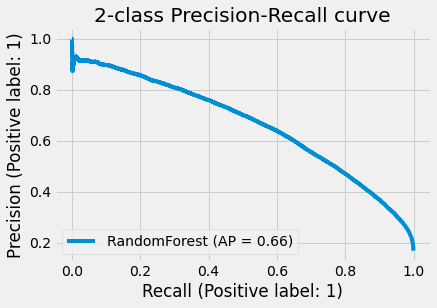

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bestForest, X_test, y_test, name="RandomForest"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [21]:
sklearn.metrics.average_precision_score(y_test, bestForest.predict_proba(X_test)[:,1])

0.663596276512017

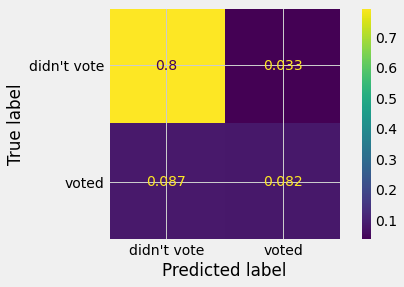

In [24]:
cm = confusion_matrix(y_test, test_pred, normalize = "all", labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["didn't vote", "voted"])
wandb.sklearn.plot_confusion_matrix(y_test, test_pred, ["didn't vote", "voted"]) 
disp.plot()
plt.show()

In [ ]:

wandb.sklearn.plot_classifier(bestForest, X_train, X_test, y_train, y_test, test_pred, test_proba, ["didn't vote", "voted"], model_name='RandomForests', feature_names = X_train.columns)

In [ ]:
wandb.finish()